# COVID-19 tweet dataset analysis: Bidirectional LSTM train and test

In this tutorial, a Bidirectional LSTM will be trained and then tested on the COVID-19 tweet dataset.
We want to get a classifier to understand if a tweet regarding COVID-19 contains real or fake news.

## PRE-ANALYSIS
Let's start with importing the necessary functions and packages for an initial pre-analysis

In [1]:
from pathlib import Path
import pandas as pd
from text_analysis.read_write_data import read_data
from text_analysis.split_dataframe import split_dataframe
from text_analysis.cleantext import rename_columns, drop_empty_rows
from text_analysis.preanalysis import info_data, plot_label_distribution
from text_analysis.preanalysis import word_count_text, char_count_text
from text_analysis.preanalysis import average_word_or_chars
from text_analysis.preanalysis import plotting_word_char_count, printer_word_chars

[nltk_data] Downloading package omw-1.4 to /home/flavio/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /home/flavio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/flavio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In the next step we will set the analysis name, which is the folder name that contains the data.
Then we set the seed in order to have a deterministic behaviour.
Finally we set the dataset folder path.

In [2]:
analysis_name = 'covid'
seed = 42
dataset_folder = Path('../datasets') / analysis_name
if not dataset_folder.is_dir():
    print('The dataset folder path links to a path which is not a folder!')

Let's see how many files there are inside the folder:

In [3]:
print(list(dataset_folder.glob('**/*.csv')))

[PosixPath('../datasets/covid/Constraint_English_Train.csv'), PosixPath('../datasets/covid/Constraint_English_Val.csv'), PosixPath('../datasets/covid/english_test_with_labels.csv')]


All the data are stored in three different csv files. 
Now we can read the data. Data are already split in train/validation/test datasets, so no needing of splitting the dataframes.

In [4]:
dfs_raw = read_data(dataset_folder)
df_train, df_val, df_test = dfs_raw

Now let's find the initial column names for the text and labels. Then we clean a little bit the dataframes: we remove rows with empty cells from the dataframes.

In [5]:
# FUNCTION FOR FINDING INITIAL COLUMN NAMES:
def find_initial_columns(analysis_name: str) -> tuple[str]:
    column_names_list = [{'analysis': 'covid',
                          'text_column': 'tweet',
                          'label_column': 'label'},
                          {'analysis': 'spam',
                           'text_column': 'original_message',
                           'label_column': 'spam'},
                           {'analysis': 'disaster',
                            'text_column': 'text',
                            'label_column': 'target'}]
    analysis_index = next((index for (index, d) in enumerate(column_names_list)
                                             if d["analysis"] == analysis_name), None)
    column_names = (column_names_list[analysis_index]['text_column'],
                    column_names_list[analysis_index]['label_column'])
    return column_names

In [6]:
text_col_name, label_col_name  = find_initial_columns(analysis_name)

df_new = []
for df in (df_train, df_val, df_test):
    # FIRST DROP ROWS WITH EMPTY CELLS AND RENAME THE COLUMNS WITH SOME STANDARD NAME: "text", "label"
    df_new.append(drop_empty_rows(rename_columns(df, text_col_name, label_col_name)))
    
df_train, df_val, df_test = df_new

Now we can see some informations about the dataframes. Then we plot label distribution.

In [7]:
info_data(df_train, df_val, df_test)

First five rows of train dataset
                                                text label
0  The CDC currently reports 99031 deaths. In gen...  real
1  States reported 1121 deaths a small rise from ...  real
2  Politically Correct Woman (Almost) Uses Pandem...  fake
3  #IndiaFightsCorona: We have 1524 #COVID testin...  real
4  Populous states can generate large case counts...  real

Description of train dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6420 entries, 0 to 6419
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    6420 non-null   object
 1   label   6420 non-null   object
dtypes: object(2)
memory usage: 100.4+ KB

Description of validation dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2140 non-null   object
 1   label   2140 non-null   object
dtypes


Train dataset label distribution:
real    3360
fake    3060
Name: label, dtype: int64

Valid dataset label distribution:
real    1120
fake    1020
Name: label, dtype: int64

Test dataset label distribution:
real    1120
fake    1020
Name: label, dtype: int64


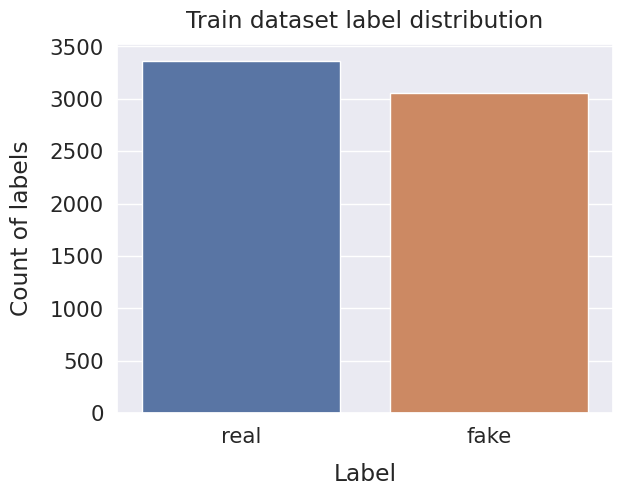

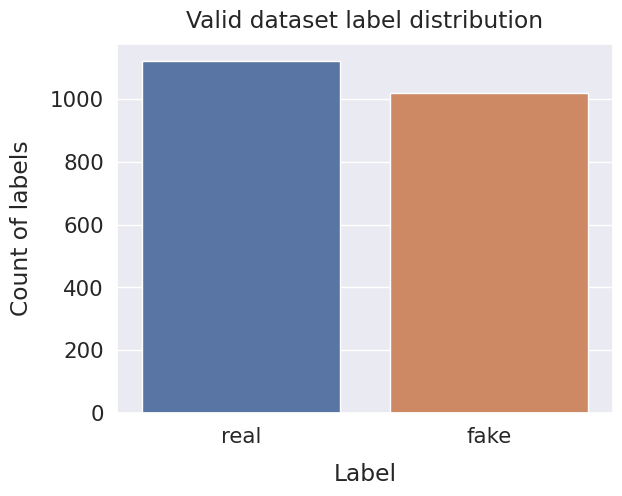

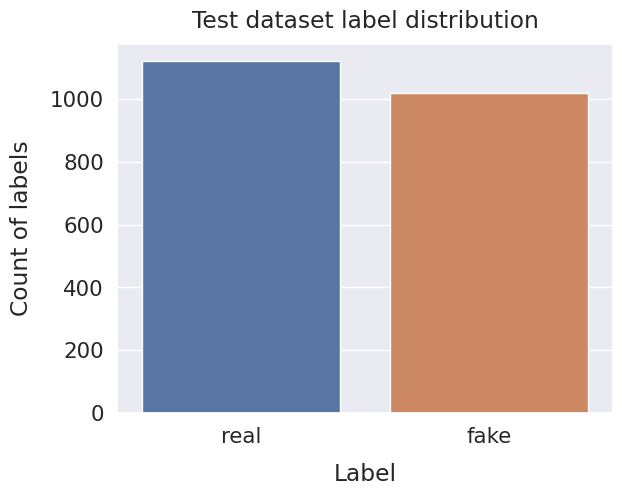

In [8]:
plot_label_distribution(df_train['label'], df_val['label'], df_test['label'])

Now we count how many words and characters for each tweet.

In [9]:
words_mean_list = []
chars_mean_list = []
for dataframe in (df_train, df_val, df_test):
    word_count = word_count_text(dataframe['text'])
    char_count = char_count_text(dataframe['text'])
    words_mean_list.append(average_word_or_chars(dataframe['label'], word_count))
    chars_mean_list.append(average_word_or_chars(dataframe['label'], char_count))
    dataframe['word_count'] = word_count
    dataframe['char_count'] = char_count

Now visualize the results just obtained.

In [10]:
printer_word_chars(words_mean_list, 'words')
printer_word_chars(chars_mean_list, 'chars')

real labels length (average words):training 31.7 validation 32.0 test 32.9
fake labels length (average words):training 21.9 validation 21.1 test 21.5
real labels length (average chars):training 215.1 validation 216.3 test 224.1
fake labels length (average chars):training 144.9 validation 139.4 test 142.0


Now we plot the word counts distribution and the character counts distribution to better see the difference in word/characters length between real and fake news about covid.

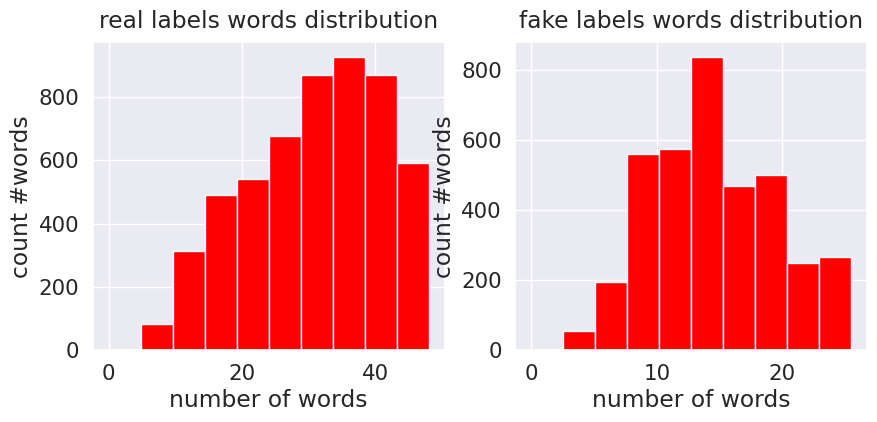

In [11]:
df_complete = pd.concat([df_train, df_val, df_test], ignore_index=True)
plotting_word_char_count(df_complete['label'], df_complete['word_count'], 'words')

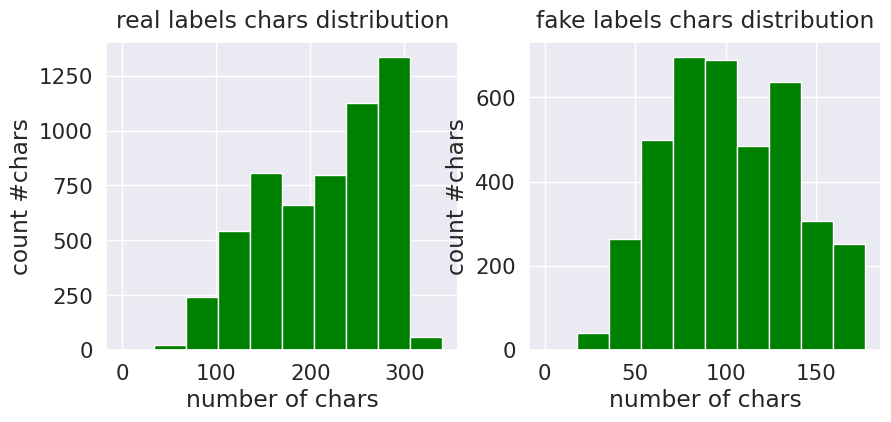

In [12]:
plotting_word_char_count(df_complete['label'], df_complete['char_count'], 'chars')

## PREPROCESS PART
We just finished the pre-analysis and now we want to clean a little bit the text in order to make a better and easier analysis for the classifier. Tweets could be composed by some characters that we don't want, for example: emoticons, URLs, tags, hastags, punctuations, special characters and so on. 
Now we will clean the text, and we will save the new cleaned datasets in another folder (called preprocessed_datasets for example).

In [13]:
from tqdm import tqdm
from text_analysis.cleantext import finalpreprocess
from text_analysis.read_write_data import write_data

In [14]:
dfs_processed = []
for df in (df_train, df_val, df_test):
    df_cleaned = df.copy()
    df_cleaned = df_cleaned[['text', 'label']]
    
    # NEW COLUMN: "clean_text" -> CLEAN THE "text" column
    df_cleaned['clean_text'] = df_cleaned['text']
    cleaned_text = [finalpreprocess(text_to_clean) for text_to_clean in tqdm(df_cleaned['clean_text'])]
    df_cleaned['clean_text'] = cleaned_text
    df_cleaned = drop_empty_rows(df_cleaned)
    dfs_processed.append(df_cleaned)
df_train, df_val, df_test = dfs_processed

100%|███████████████████████████████████████| 2140/2140 [00:34<00:00, 61.72it/s]


(OPTIONAL) We can write the preprocessed datasets in a new folder.

In [15]:
output_folder = Path('preprocessed_datasets') / analysis_name
output_folder.mkdir(parents=True, exist_ok=True)

write_data(dfs_processed, output_folder = output_folder, analysis = analysis_name)

In [16]:
print(df_train['clean_text'].head())
print("="*40)
print(df_val['clean_text'].head())
print("="*40)
print(df_test['clean_text'].head())

0    cdc currently report 99031 death general discr...
1    state report 1121 death small rise last tuesda...
2    politically correct woman almost use pandemic ...
3    indiafightscorona 1524 covid test laboratory i...
4    populous state generate large case count look ...
Name: clean_text, dtype: object
0    chinese convert islam realise muslim affect co...
1    11 13 people diamond princess cruise ship inti...
2         covid 19 cause bacterium virus treat aspirin
3    mike penny rnc speech praise donald trump covi...
4    6 10 sky edconwaysky explain late covid19 data...
Name: clean_text, dtype: object
0    daily update publish state report 734k test 39...
1                                alfalfa cure covid 19
2    president trump ask would catch coronavirus do...
3    state report 630 death still see solid nationa...
4    sixth time global health emergency declare int...
Name: clean_text, dtype: object


In [17]:
print("Some random texts:\n" + "="*40)
for index, row in df_train.sample(n = 3).iterrows():
    print("\nOriginal text:\n" + "="*40) 
    print(row['text'])
    print("\nCleaned text:\n" + "="*40)
    print(row['clean_text'])

Some random texts:

Original text:
The NZ COVID Tracker app will remain important and useful at Alert level 1. People are encouraged to download the app or a similar one or keep a record of where you’re going to be.

Cleaned text:
nz covid tracker app remain important useful alert level 1 people encourage download app similar one keep record go

Original text:
#CoronaVirusUpdates: #COVID19 testing status update: @ICMRDELHI stated that 062454254 samples tested up to September 18 2020 0881911 samples tested on September 18 2020 #StaySafe #IndiaWillWin https://t.co/woTsjKCV4D

Cleaned text:
coronavirusupdates covid19 test status update icmrdelhi state 062454254 sample test september 18 2020 0881911 sample test september 18 2020 staysafe indiawillwin

Original text:
Colombia is the last country in the coronavirus test ranking.

Cleaned text:
colombia last country coronavirus test ranking


## TRAINING BIDIRECTIONAL LSTM 
Now we will vectorize data and then train a Bidrectional LSTM model.
Firstly we will import the needed functions and packages.

In [18]:
from text_analysis.vectorize_data import get_vocabulary, tocat_encode_labels
from text_analysis.vectorize_data import init_vector_layer, vectorize_X_data_tf, calculate_max_len
from text_analysis.vectorize_data import flatten_unique_voc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.layers import Embedding

2022-12-08 11:41:42.428501: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 11:41:45.674246: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/flavio/root/lib
2022-12-08 11:41:45.674602: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/flavio/root/lib
2022-12-08 11:41:45.674634: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

Now we set some parameters: embedding_vector_size is the output vector size after the Embedding layer, batch_size, epochs, learning_rate are parameters for the training of the neural network, checkpoint_path is the checkpoint path where to save the model.

In [19]:
embedding_vector_size = 32
epochs = 200
learning_rate = 1e-4
batch_size = 64
checkpoint_path = Path('checkpoint') / analysis_name

Now we get the vocabulary. We need a list of strings, which each string is a unique token (unique word).
We compute also maxlen, which is the maximum number the vector length after the vectorization layer (it's the input vector length to the Embedding layer). 

In [20]:
all_train_words = list(df_train['clean_text']) + list(df_val['clean_text'])
vocabulary = get_vocabulary(all_train_words)
unique_vocabulary = flatten_unique_voc(vocabulary)
maxlen = calculate_max_len(df_train['clean_text']) 

Now we can vectorize the text using a TextVectorization layer (from tensorflow).

In [21]:
vectorize_layer = init_vector_layer(maxlen, unique_vocabulary)

X_train = vectorize_X_data_tf(df_train['clean_text'], vectorize_layer)
X_valid = vectorize_X_data_tf(df_val['clean_text'], vectorize_layer)

y_train = tocat_encode_labels(df_train['label'])
y_valid = tocat_encode_labels(df_val['label'])

2022-12-08 11:42:15.731810: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-08 11:42:15.731986: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (FLAVIOPC): /proc/driver/nvidia/version does not exist
2022-12-08 11:42:15.737209: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Now we can build our model writing the function to build the model:

In [22]:
def build_model(vocab_size: int,
                embedding_dim: int, 
                maxlen: int) -> tf.keras.models.Sequential:
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        input_length=maxlen))
    model.add(Bidirectional(LSTM(64, recurrent_dropout=0)))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation = 'relu'))
    model.add(Dropout(0.25))    
    model.add(Dense(1, activation='sigmoid'))

    return model

In [23]:
vocab_size = len(vectorize_layer.get_vocabulary()) # number of tokens inside the vocabulary

model = build_model(vocab_size = vocab_size,
                        embedding_dim = embedding_vector_size,
                        maxlen = maxlen)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 49, 32)            449056    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              49664     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                        

Now we can compile the model. For the training of the model the binary cross entropy loss is chosen, the optimizer is Adam, and accuracy is used as metrics.

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

We can define two different callbacks: early stopping and model checkpoint.
The first callback (early stopping) is used to stop the training, while there is a condition of overfitting (this callback monitors the validation loss).
The second callback (model checkpoint) is used to save the model when there is an improvement in the validation accuracy. 

In [25]:
# CHECKPOINT CALLBACK
checkpoint_path.mkdir(parents = True, exist_ok = True)
checkpoint_model_path = checkpoint_path / 'best_model.hdf5' 
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint( filepath=checkpoint_model_path,
                                                                save_weights_only=True,
                                                                monitor='val_accuracy',
                                                                mode='max',
                                                                save_best_only=True )

# EARLY STOP CALLBACK
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [26]:
# TRAIN
history = model.fit( x=X_train,
                     y=y_train,
                     validation_data=(X_valid, y_valid),
                     callbacks = [model_checkpoint_callback, early_stop_callback],
                     batch_size=batch_size,
                     epochs=epochs)

Epoch 1/200
101/101 [==============================] - 30s 151ms/step - loss: 0.6906 - accuracy: 0.5249 - val_loss: 0.6830 - val_accuracy: 0.5234
Epoch 2/200
101/101 [==============================] - 12s 119ms/step - loss: 0.6522 - accuracy: 0.5701 - val_loss: 0.5904 - val_accuracy: 0.6972
Epoch 3/200
101/101 [==============================] - 11s 109ms/step - loss: 0.5374 - accuracy: 0.7625 - val_loss: 0.4453 - val_accuracy: 0.8266
Epoch 4/200
101/101 [==============================] - 11s 110ms/step - loss: 0.4159 - accuracy: 0.8296 - val_loss: 0.3613 - val_accuracy: 0.8509
Epoch 5/200
101/101 [==============================] - 13s 127ms/step - loss: 0.3437 - accuracy: 0.8723 - val_loss: 0.3020 - val_accuracy: 0.8888
Epoch 6/200
101/101 [==============================] - 12s 118ms/step - loss: 0.2892 - accuracy: 0.9014 - val_loss: 0.2717 - val_accuracy: 0.8995
Epoch 7/200
101/101 [==============================] - 12s 120ms/step - loss: 0.2483 - accuracy: 0.9184 - val_loss: 0.3168 -

## EVALUATE BIDIRECTIONAL LSTM MODEL
At this point we can evaluate the Bidirectional LSTM model with the test dataset. We will load the Bidirectional LSTM model to test it. Firstly import the needed functions.

In [27]:
from text_analysis.results import visualize_results

Now we define some paths (plot path is where to save the plots we will generate).

In [28]:
plot_path = Path('plots') / analysis_name
plot_path.mkdir(parents = True, exist_ok = True)

Now we can load the Bidirectional LSTM model.

In [29]:
checkpoint_path_weights_nn = checkpoint_path / 'best_model.hdf5'
new_model = build_model(vocab_size = vocab_size,
                        embedding_dim = embedding_vector_size,
                        maxlen = maxlen)
new_model.summary()
new_model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics = [tf.keras.metrics.Accuracy()])

new_model.load_weights(checkpoint_path_weights_nn)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 49, 32)            449056    
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              49664     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 32)                4128      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                330       
                                                      

Vectorization of the text data; label encoding of the labels.

In [30]:
X_test = vectorize_X_data_tf(df_test['clean_text'], vectorize_layer)
y_test, classes  = tocat_encode_labels(df_test['label'], classes = True)

Evaluate the Bidirectional LSTM model

In [31]:
# evaluate the model
y_prob = model.predict(X_test)
y_predict = y_prob
y_predict[y_prob > 0.5] = 1
y_predict[y_prob <= 0.5] = 0

loss, acc = model.evaluate(X_test, y_test, verbose=2)

67/67 [==============================] - 4s 26ms/step
67/67 - 2s - loss: 0.3212 - accuracy: 0.9173 - 2s/epoch - 25ms/step


Let's visualize the results.
We will visualize the confusion matrix and also the training history (graphs regarding train loss, val loss, train accuracy and val accuracy).

              precision    recall  f1-score   support

           0       0.90      0.93      0.91      1020
           1       0.94      0.90      0.92      1120

    accuracy                           0.92      2140
   macro avg       0.92      0.92      0.92      2140
weighted avg       0.92      0.92      0.92      2140

Confusion Matrix: [[ 950   70]
 [ 107 1013]]
AUC: 0.9179184173669468


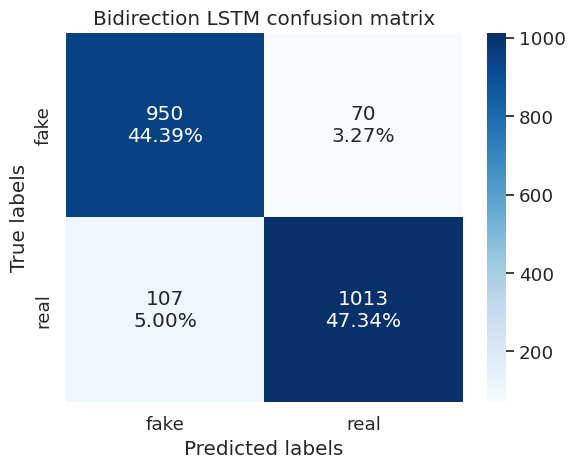

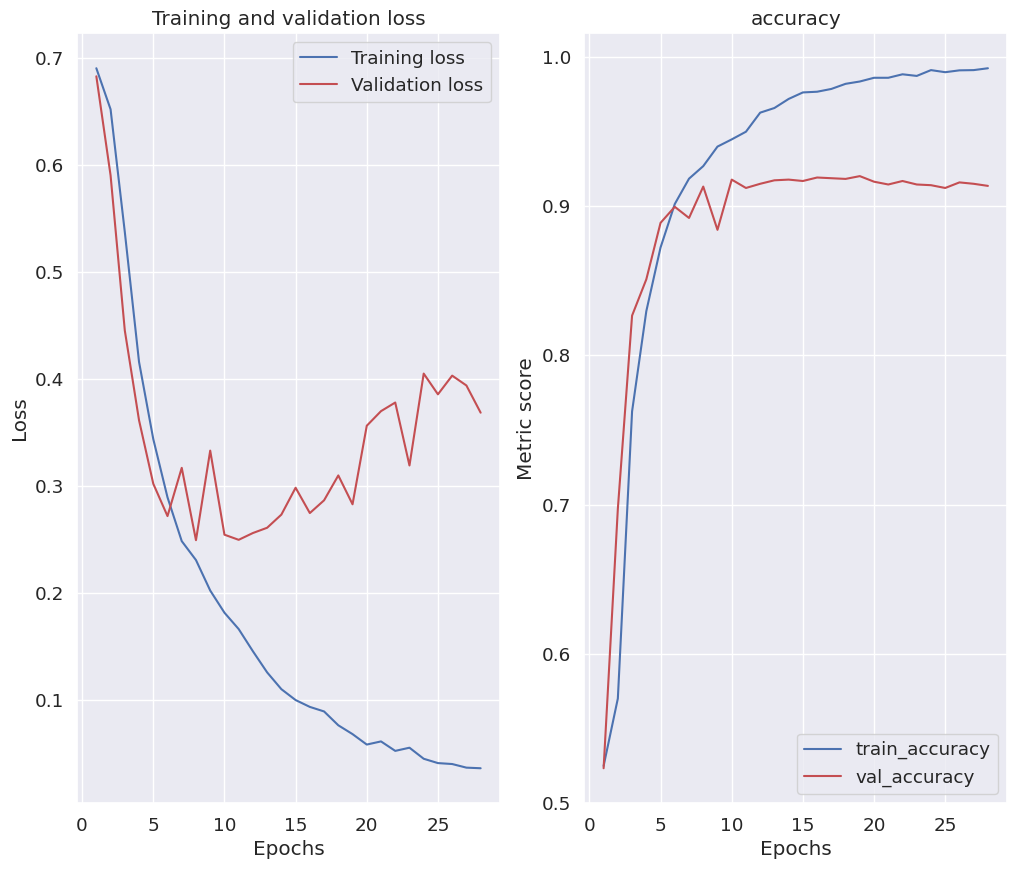

LSTM model, accuracy: 91.73%


In [33]:
history_df = history.history
visualize_results(y_test, y_predict, y_prob, list(classes),
                  name_model = 'Bidirection LSTM',
                  metrics = ['accuracy'],
                  history = history_df,
                  folder_path=plot_path
                  )
print("LSTM model, accuracy: {:5.2f}%".format(100 * acc))

We have obtained a simple Bidirectional LSTM model with an 92% of accuracy on the Covid-19 tweet dataset!